In [49]:
# Import modules
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [51]:
new_data = pd.read_csv('data/new_data.csv')

In [39]:
#enlabel the columns
new_data = new_data
new_data['admission_type_id'] = pd.Categorical(new_data.admission_type_id)
new_data['discharge_disposition_id'] = pd.Categorical(new_data.discharge_disposition_id)
new_data['admission_source_id'] = pd.Categorical(new_data.admission_source_id)

cat_cols = list(new_data.select_dtypes(include=[object]).columns)
for col in cat_cols:
   new_data[col] = pd.Categorical(new_data[col])

le = preprocessing.LabelEncoder()

col_to_encode = new_data[list(new_data.select_dtypes(include=['category']).columns)]
for col in col_to_encode:
   new_data[col] = le.fit_transform(new_data[col])


In [ ]:
### 1

In [22]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
#confusion matrix
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[18112     0]
 [ 2242     0]]


In [24]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     18112
          1       0.00      0.00      0.00      2242

avg / total       0.79      0.89      0.84     20354



/Users/jasonwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
print(classifier.coef_)

[[-8.26591365e-09 -8.75211822e-09 -2.76826297e-15 -8.16793953e-16
  -9.98396320e-15 -2.52944600e-15 -5.66836765e-15 -8.92920786e-15
  -7.17411014e-15 -4.00652337e-14 -7.41589917e-14 -2.66421030e-15
  -2.36100168e-14  8.43252403e-17  3.65971852e-16  6.80812964e-16
  -1.05368121e-14 -3.47707696e-15 -3.24571414e-15 -2.12147843e-15
  -1.75472808e-15 -1.75991777e-15 -1.75911806e-15 -1.83364364e-15
  -8.89502423e-20 -1.97334295e-15 -2.02141440e-15 -1.16747010e-18
  -1.84538148e-15 -1.88866476e-15 -1.76057857e-15 -1.75564334e-15
  -2.57094134e-19 -2.35351221e-18  0.00000000e+00  0.00000000e+00
  -2.34631133e-15 -1.75381893e-15 -1.23945996e-19 -2.75735461e-20
  -4.16020130e-21 -7.15076168e-21 -1.20366741e-15 -1.18473713e-15
   2.30029994e-15 -1.34139096e-16 -1.47132556e-14 -1.39586423e-14
  -1.41544255e-14 -8.92043444e-18 -1.48751373e-17 -1.03624577e-16]]


In [ ]:
#### 2

In [40]:
#creating a training and testing datasets
y = new_data.readmitin30days
X_train, X_test, y_train, y_test = train_test_split(new_data, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(81412, 52) (81412,)
(20354, 52) (20354,)


In [41]:
decision_logit = linear_model.LogisticRegression(C=1e4)
## Fit the model with your data
decision_logit.fit(X_train, y_train)

## The score (accuracy for classification problems):
decision_logit.score(X_train, y_train)

0.8880877511914705

In [63]:
decision_logit.coef_

array([[-8.27929110e-09, -8.63157146e-09, -2.79429872e-15,
        -8.29611817e-16, -1.01055291e-14, -2.52559263e-15,
        -5.81377220e-15, -8.97889840e-15, -7.31756615e-15,
        -4.06213808e-14, -7.47991107e-14, -2.69712827e-15,
        -2.40929127e-14,  8.14240632e-17,  3.65971656e-16,
         7.30562095e-16, -1.06910867e-14, -3.51493737e-15,
        -3.26347350e-15, -2.16151504e-15, -1.77556945e-15,
        -1.77944156e-15, -1.77950914e-15, -1.85222952e-15,
        -8.93806433e-20, -2.00209939e-15, -2.04301947e-15,
        -1.30719029e-18, -1.86474463e-15, -1.91422952e-15,
        -1.78101855e-15, -1.77561037e-15, -4.00050648e-19,
        -2.11875213e-18,  0.00000000e+00,  0.00000000e+00,
        -2.34129345e-15, -1.77545490e-15, -2.90338380e-19,
         0.00000000e+00, -1.86386394e-20, -7.18612993e-21,
        -1.20825592e-15, -1.20046926e-15,  2.30855204e-15,
        -1.44071850e-16, -1.50954910e-14, -1.42633766e-14,
        -1.43098693e-14, -7.08241908e-18, -1.70748246e-1

In [84]:
decision_logit_df = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(decision_logit.coef_).T], axis=1)
decision_logit_df.columns = ["Col", "Coef"]
decision_logit_df = decision_logit_df.sort_values(by="Coef", ascending = False)
decision_logit_df

,Col,Coef
44,readmitin30days,2.308552e-15
15,number_inpatient,7.305621e-16
14,number_emergency,3.659717e-16
13,number_outpatient,8.142406e-17
35,citoglipton,0.000000e+00
39,glimepiride-pioglitazone,0.000000e+00
34,examide,0.000000e+00
41,metformin-pioglitazone,-7.186130e-21
40,metformin-rosiglitazone,-1.863864e-20
24,acetohexamide,-8.938064e-20


In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(decision_logit, new_data, new_data.readmitin30days, cv=5)
scores

array([0.88837575, 0.88837575, 0.8884194 , 0.8884194 , 0.88841392])

In [35]:
# create the RFE model and select 3 attributes

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 3)
rfe = rfe.fit(new_data, y)
print(rfe.n_features_)
print(rfe.support_)
print(rfe.ranking_)

3
[ True  True False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[ 1  1 14 33  8 16 11  9 10  2  1 15  3 38 35 34  7 12 13 19 30 27 26 24
 45 21 20 42 23 22 25 28 43 41 49 50 17 29 44 46 47 48 31 32 18 36  4  6
  5 40 39 37]


In [72]:
new_data.shape

(101766, 52)

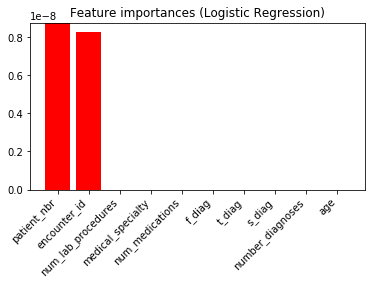

In [15]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(max_iter=3000)
clf.fit(X_train, y_train)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), new_data.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ion(); plt.show()